In [1]:
# Import basic qiskit libraries
from qiskit import QuantumCircuit, transpile, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from qiskit.circuit.library import u3

basis = ['rz', 'sx', 'x', 'cx']

### A simple demonstration of the inbuilt Hoare Optimizer

In [2]:
# Create the base custom gate
custom_gate = QuantumCircuit(1)
custom_gate.u(0.1, 0.2, 0.3, 0)

# Turn it into a Gate and control it
custom_gate = custom_gate.to_gate(label='custom_gate')
cc_custom_gate = custom_gate.control(2)

# Take the Hermitian of the full controlled gate
cc_custom_gate_dagger = cc_custom_gate.inverse()

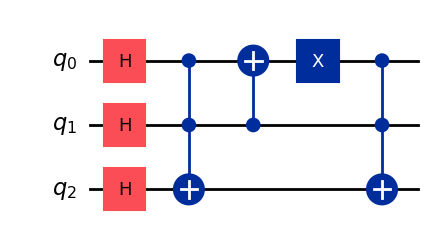

In [3]:
# Create a sample circuit
qc = QuantumCircuit(3)

# Init
qc.h(0)
qc.h(1)
qc.h(2)

# Apply
qc.ccx(0, 1, 2)
qc.cx(1, 0)
qc.x(0)
qc.ccx(0, 1, 2)

# Draw the circuit
qc.draw('mpl')

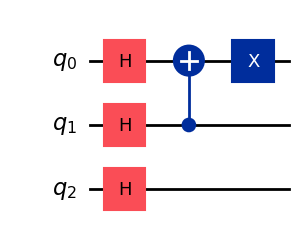

In [4]:
# Run the Hoare Optimizer
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import HoareOptimizer

pass_manager = PassManager()
pass_manager.append(HoareOptimizer())

# Transpile the circuit
optimized_circ = pass_manager.run(qc)
# Draw the optimized circuit
optimized_circ.draw('mpl')

In [5]:
# Compare gate counts
qc = transpile(qc, basis_gates=basis, optimization_level=3)
optimized_circ = transpile(optimized_circ, basis_gates=basis, optimization_level=3)
print("Original circuit gate count: ", qc.count_ops())
print("Optimized circuit gate count: ", optimized_circ.count_ops())

Original circuit gate count:  OrderedDict({'rz': 17, 'cx': 11, 'sx': 7})
Optimized circuit gate count:  OrderedDict({'rz': 6, 'sx': 3, 'cx': 1, 'x': 1})


### Does it work across Measurements??

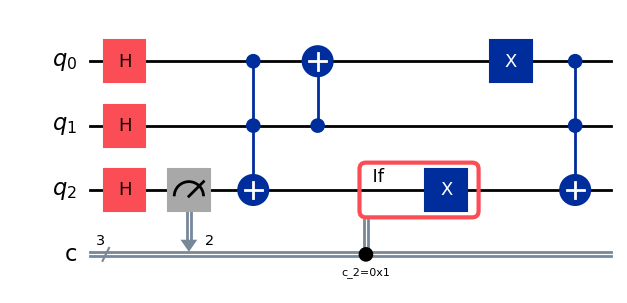

In [6]:
# Work across the same example, but with a measurement
qc_0 = QuantumCircuit(3, 3)

# Init
qc_0.h(0)
qc_0.h(1)
qc_0.h(2)

# Measure the third qubit
qc_0.measure(2, 2)

# Apply (before measurement)
qc_0.ccx(0, 1, 2)
qc_0.cx(1, 0)

# Conditional on the measurement
with qc_0.if_test((2, 1)):
    qc_0.x(2)

# Apply (after measurement)
qc_0.x(0)
qc_0.ccx(0, 1, 2)

# Draw the circuit
qc_0.draw('mpl')

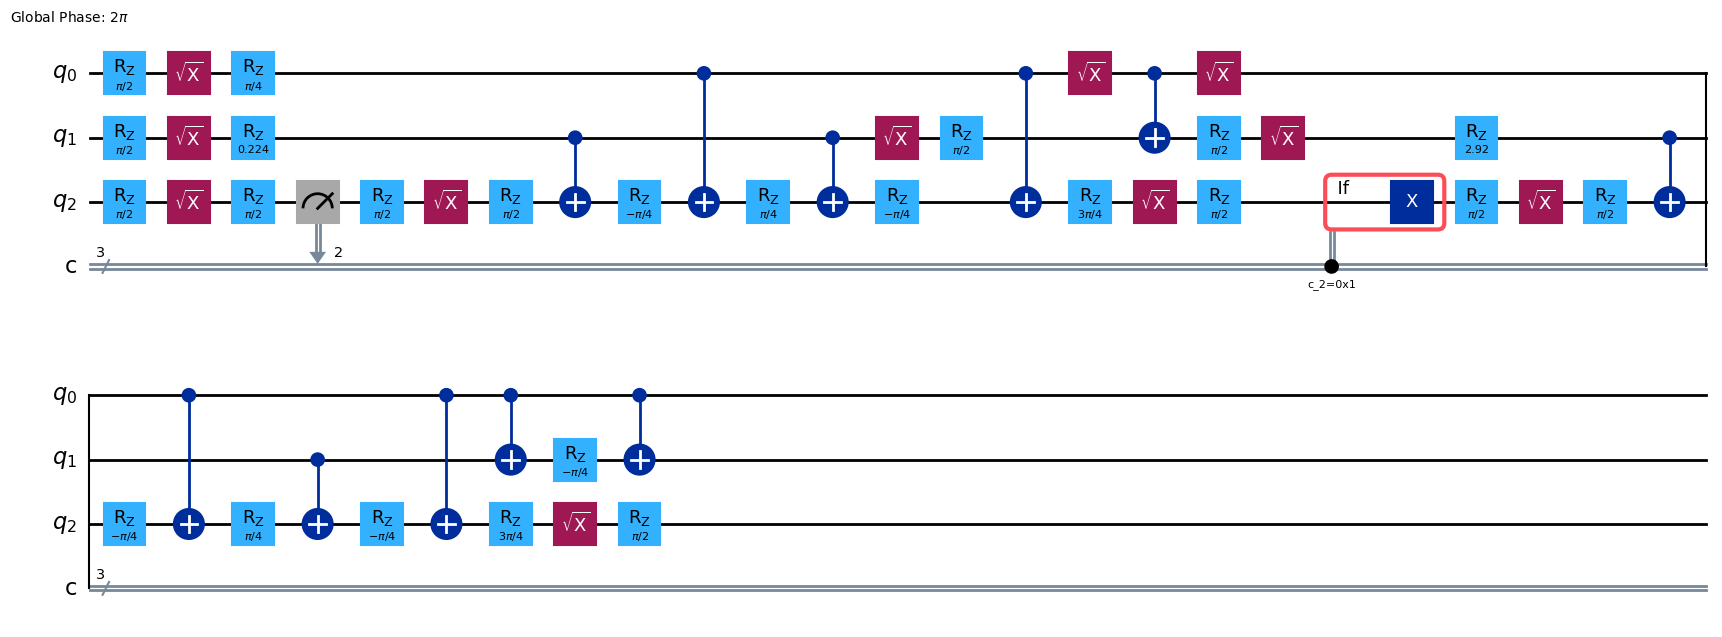

In [7]:
# Run the Hoare Optimizer
opt_0 = pass_manager.run(qc_0)

# Run full transpilation
opt_0 = transpile(opt_0, optimization_level=3, basis_gates=basis)

# Draw the optimized circuit
opt_0.draw('mpl')

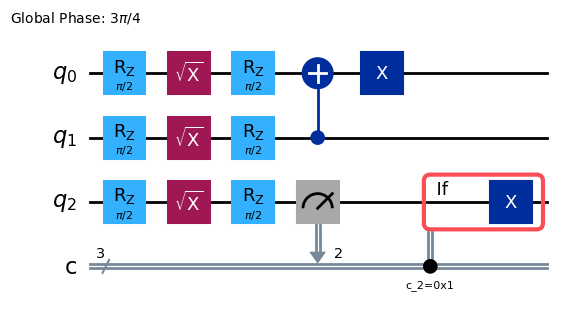

In [8]:
# Better Circuit
bet_0 = QuantumCircuit(3, 3)

# Init
bet_0.h(0)
bet_0.h(1)
bet_0.h(2)

# Measure the third qubit
bet_0.measure(2, 2)

# Stuff
bet_0.cx(1, 0)
bet_0.x(0)
with bet_0.if_test((2, 1)):
    bet_0.x(2)

# Draw the circuit
bet_0 = transpile(bet_0, optimization_level=3, basis_gates=basis)
bet_0.draw('mpl')

In [9]:
# Gate Count Comparison
print("Original Circuit Gate Count: ", opt_0.count_ops())
print("Optimized Circuit Gate Count: ", bet_0.count_ops())

Original Circuit Gate Count:  OrderedDict({'rz': 24, 'sx': 11, 'cx': 11, 'measure': 1, 'if_else': 1})
Optimized Circuit Gate Count:  OrderedDict({'rz': 6, 'sx': 3, 'cx': 1, 'x': 1, 'measure': 1, 'if_else': 1})


### Constant Folding on Measurements??

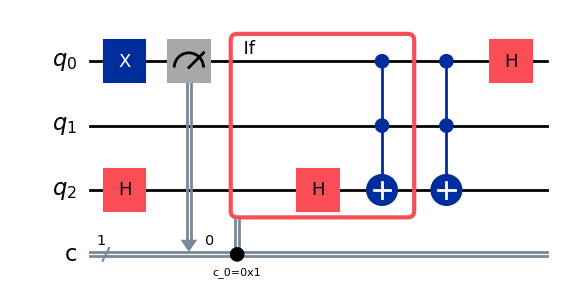

In [10]:
# Sample circuit
qc_1 = QuantumCircuit(3, 1)

# Init
qc_1.x(0)
qc_1.h(2)

# Measure
qc_1.measure(0, 0)

# If
with qc_1.if_test((0, 1)):
    qc_1.h(2)
    qc_1.ccx(0, 1, 2)

# After
qc_1.ccx(0, 1, 2)
qc_1.h(0)

# Draw the circuit
qc_1.draw('mpl')

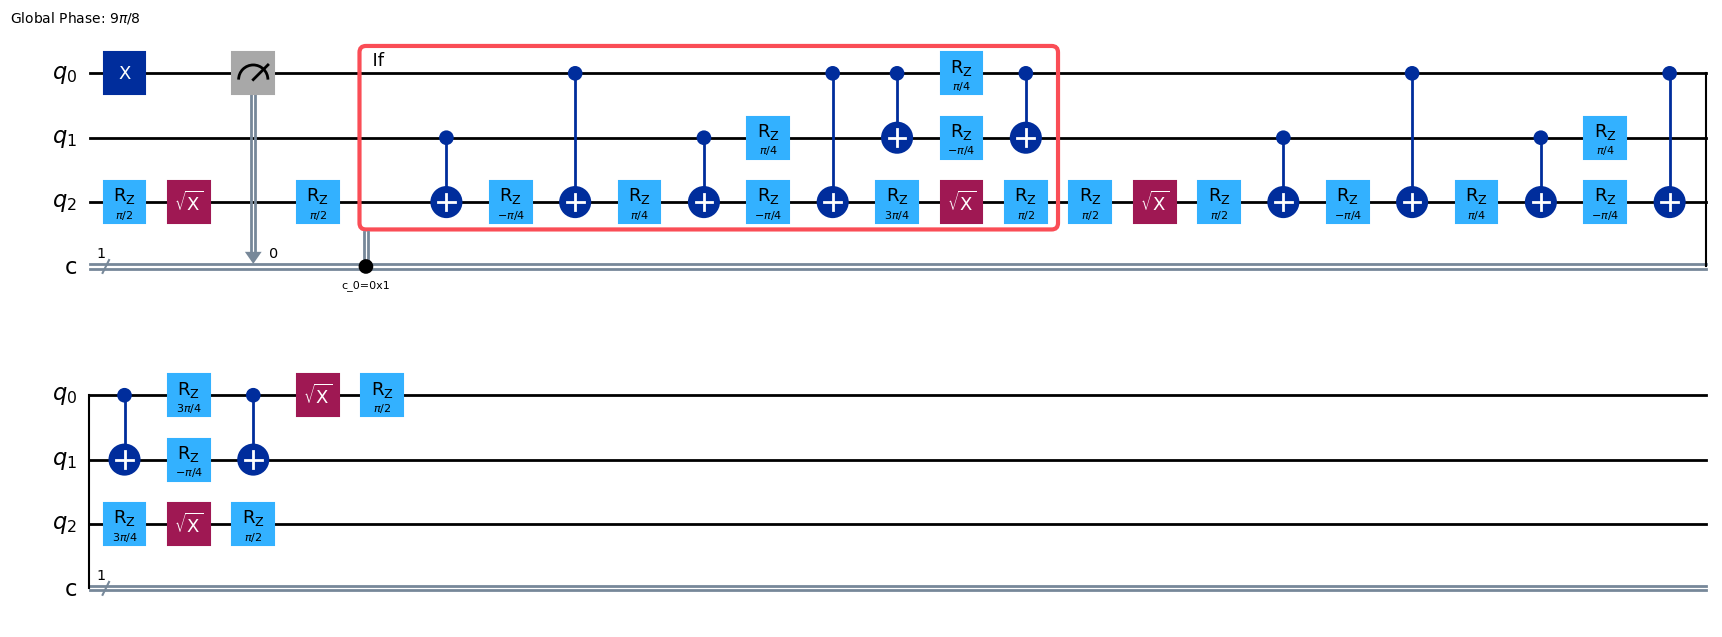

In [11]:
# Hoare Optimizer
opt_2 = pass_manager.run(qc_1)
# Transpile the circuit
opt_2 = transpile(opt_2, optimization_level=3, basis_gates=basis)

# Draw the optimized circuit
opt_2.draw('mpl')

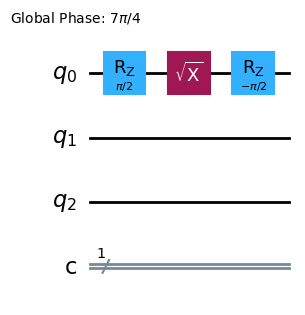

In [24]:
# Better Circuit
bet_2 = QuantumCircuit(3, 1)

# Just two things
bet_2.x(0)
bet_2.h(0)

# Draw the circuit
bet_2 = transpile(bet_2, optimization_level=3, basis_gates=basis)
bet_2.draw('mpl')

In [25]:
# Gate Count Comparison
print("Original Circuit Gate Count: ", opt_2.count_ops())
print("Optimized Circuit Gate Count: ", bet_2.count_ops())

Original Circuit Gate Count:  OrderedDict({'rz': 13, 'cx': 6, 'sx': 4, 'x': 1, 'measure': 1, 'if_else': 1})
Optimized Circuit Gate Count:  OrderedDict({'rz': 2, 'sx': 1})


### Can we transfer stuff? [Value-Independent]

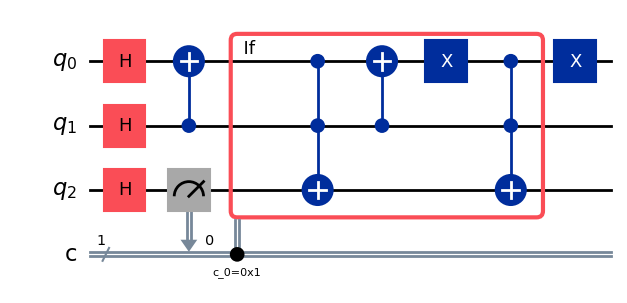

In [14]:
# Original circuit but in a conditional blocks
qc_3 = QuantumCircuit(3, 1)

# Before measurement
qc_3.h(0)
qc_3.h(1)
qc_3.h(2)
qc_3.cx(1, 0)

# Measure
qc_3.measure(2, 0)

# If
with qc_3.if_test((0, 1)):
    qc_3.ccx(0, 1, 2)
    qc_3.cx(1, 0)
    qc_3.x(0)
    qc_3.ccx(0, 1, 2)

# After
qc_3.x(0)

# Draw the circuit
qc_3.draw('mpl')

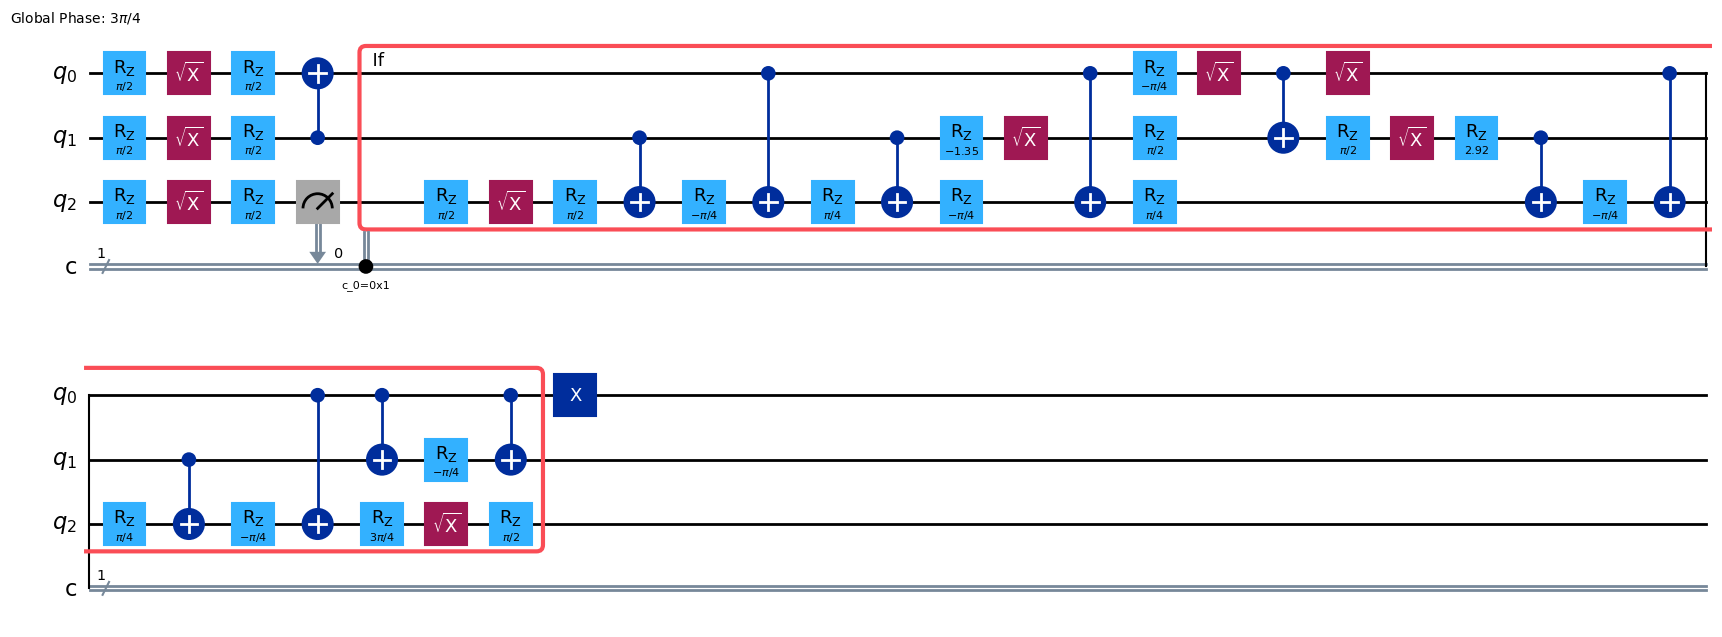

In [15]:
# Hoare Optimizer
opt_3 = pass_manager.run(qc_3)
# Transpile the circuit
opt_3 = transpile(opt_3, optimization_level=3, basis_gates=basis)

# Draw the optimized circuit
opt_3.draw('mpl')

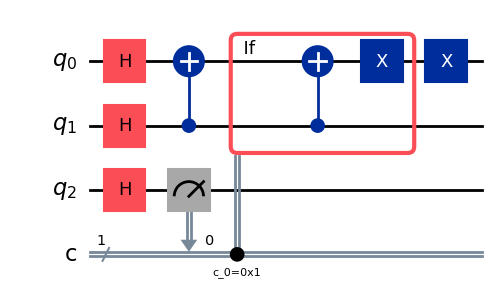

In [16]:
# Better Circuit (Ver 1)
bet_3a = QuantumCircuit(3, 1)

# Stuff
bet_3a.h(0)
bet_3a.h(1)
bet_3a.h(2)
bet_3a.cx(1, 0)
bet_3a.measure(2, 0)

# If
with bet_3a.if_test((0, 1)):
    bet_3a.cx(1, 0)
    bet_3a.x(0)

# After
bet_3a.x(0)

# Draw the circuit
bet_3a.draw('mpl')

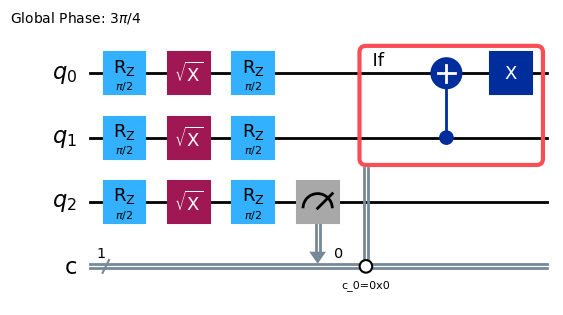

In [17]:
# Better Circuit (Ver 2)
bet_3b = QuantumCircuit(3, 1)

# Stuff
bet_3b.h(0)
bet_3b.h(1)
bet_3b.h(2)

# Measure
bet_3b.measure(2, 0)

# If
with bet_3b.if_test((0, 0)):
    bet_3b.cx(1, 0)
    bet_3b.x(0)

# Draw the circuit
bet_3b = transpile(bet_3b, optimization_level=3, basis_gates=basis)
bet_3b.draw('mpl')

In [18]:
# Gate Count Comparison
print("Original Circuit Gate Count: ", opt_3.count_ops())
print("Optimized Circuit Gate Count: ", bet_3b.count_ops())

Original Circuit Gate Count:  OrderedDict({'rz': 6, 'sx': 3, 'cx': 1, 'measure': 1, 'if_else': 1, 'x': 1})
Optimized Circuit Gate Count:  OrderedDict({'rz': 6, 'sx': 3, 'measure': 1, 'if_else': 1})


### Transfer via value-dependent Hoare Optimization

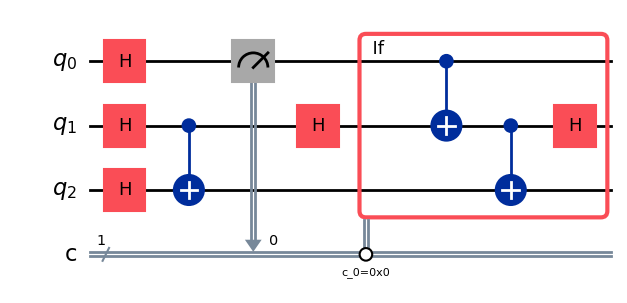

In [19]:
# Value-dependent Hoare Optimizer Sample
qc_4 = QuantumCircuit(3, 1)

# Before measurement
qc_4.h(0)
qc_4.h(1)
qc_4.h(2)
qc_4.cx(1, 2)
qc_4.h(1)

# Measure
qc_4.measure(0, 0)
# If
with qc_4.if_test((0, 0)):
    qc_4.cx(0, 1)
    qc_4.cx(1, 2)
    qc_4.h(1)

# Draw the circuit
qc_4.draw('mpl')

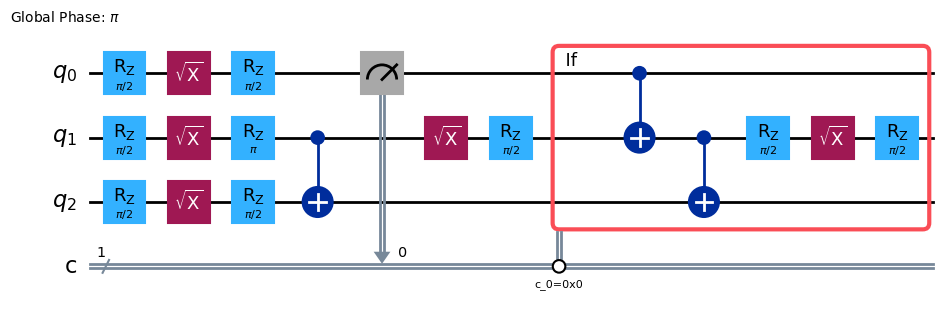

In [20]:
# Hoare Optimizer
opt_4 = pass_manager.run(qc_4)
# Transpile the circuit
opt_4 = transpile(opt_4, optimization_level=3, basis_gates=basis)

# Draw the optimized circuit
opt_4.draw('mpl')

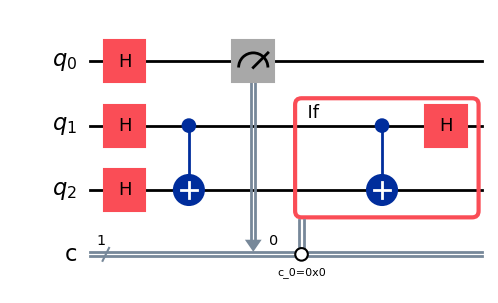

In [21]:
# Better Circuit (Version 1)
bet_4a = QuantumCircuit(3, 1)

# Stuff
bet_4a.h(0)
bet_4a.h(1)
bet_4a.h(2)
bet_4a.cx(1, 2)

# Measure
bet_4a.measure(0, 0)

# If
with bet_4a.if_test((0, 0)):
    bet_4a.cx(1, 2)
    bet_4a.h(1)

# Draw the circuit

bet_4a.draw('mpl')

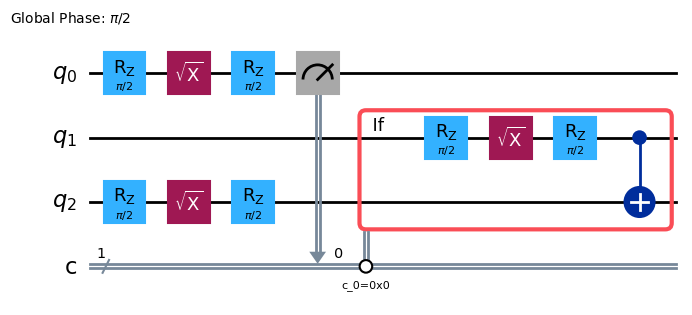

In [22]:
# Better Circuit
bet_4b = QuantumCircuit(3, 1)

# Stuff
bet_4b.h(0)
bet_4b.h(2)

# Measure
bet_4b.measure(0, 0)

# If
with bet_4b.if_test((0, 0)):
    bet_4b.h(1)
    bet_4b.cx(1, 2)

# Draw the circuit
bet_4b = transpile(bet_4b, optimization_level=3, basis_gates=basis)
bet_4b.draw('mpl')


In [23]:
# Gate Count Comparison
print("Original Circuit Gate Count: ", opt_4.count_ops())
print("Optimized Circuit Gate Count: ", bet_4b.count_ops())

Original Circuit Gate Count:  OrderedDict({'rz': 7, 'sx': 4, 'cx': 1, 'measure': 1, 'if_else': 1})
Optimized Circuit Gate Count:  OrderedDict({'rz': 4, 'sx': 2, 'measure': 1, 'if_else': 1})
